In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pandas as pd

# Importing train data csv

In [2]:
#importing the train csv

import pandas as pd

plants=pd.read_csv('../plantbase/data/priority_plants_VF.csv').drop(columns='Unnamed: 0')

In [3]:
plants.head(10)

,id,family,genus,species,content
0,100005,Lamiaceae,Ajuga,Ajuga reptans L.,Flower
1,100038,Iridaceae,Iris,Iris lutescens Lam.,Flower
2,100144,Malvaceae,Malva,Malva sylvestris L.,Flower
3,10019,Orchidaceae,Ophrys,Ophrys apifera Huds.,Flower
4,100190,Geraniaceae,Geranium,Geranium sylvaticum L.,Flower
5,100201,Rosaceae,Crataegus,Crataegus germanica (L.) Kuntze,Flower
6,100229,Fabaceae,Trifolium,Trifolium alpinum L.,Flower
7,100255,Violaceae,Viola,Viola odorata L.,Flower
8,100273,Scrophulariaceae,Verbascum,Verbascum thapsus L.,Flower
9,100303,Rosaceae,Crataegus,Crataegus germanica (L.) Kuntze,Flower


# Understanding the train data balance & setting class_weights

In [4]:
#Class names based on genus
class_names={0: 'Ajuga',
 1: 'Allium',
 2: 'Campanula',
 3: 'Cirsium',
 4: 'Crataegus',
 5: 'Gentiana',
 6: 'Geranium',
 7: 'Iris',
 8: 'Malva',
 9: 'Narcissus',
 10: 'Ophrys',
 11: 'Rosa',
 12: 'Trifolium',
 13: 'Verbascum',
 14: 'Veronica',
 15: 'Viola'}

In [5]:
#flipping the dictionary so we can assign class number to every genus
class_numbers= {} 
for key, value in class_names.items(): 
   if value in class_numbers: 
       class_numbers[value].append(key) 
   else: 
       class_numbers[value]=key 
        
class_numbers

{'Ajuga': 0,
 'Allium': 1,
 'Campanula': 2,
 'Cirsium': 3,
 'Crataegus': 4,
 'Gentiana': 5,
 'Geranium': 6,
 'Iris': 7,
 'Malva': 8,
 'Narcissus': 9,
 'Ophrys': 10,
 'Rosa': 11,
 'Trifolium': 12,
 'Verbascum': 13,
 'Veronica': 14,
 'Viola': 15}

In [6]:
#Assigning the class number to each genus
plants['class']=plants['genus'].map(class_numbers)

plants.head()

,id,family,genus,species,content,class
0,100005,Lamiaceae,Ajuga,Ajuga reptans L.,Flower,0
1,100038,Iridaceae,Iris,Iris lutescens Lam.,Flower,7
2,100144,Malvaceae,Malva,Malva sylvestris L.,Flower,8
3,10019,Orchidaceae,Ophrys,Ophrys apifera Huds.,Flower,10
4,100190,Geraniaceae,Geranium,Geranium sylvaticum L.,Flower,6


In [7]:
#understanding how unbalanced our data set is
plants.groupby('class').count().sort_values(by='id',ascending=True)

,id,family,genus,species,content
class,,,,,
0,119,119,119,119,119
11,150,150,150,150,150
7,154,154,154,154,154
4,183,183,183,183,183
14,200,200,200,200,200
12,214,214,214,214,214
9,223,223,223,223,223
3,231,231,231,231,231
1,232,232,232,232,232


In [8]:
#setting class_weights based on the class 10. 
#Essentially we treating every instance of the classes as instances of class 10
# For example weight of 4 for class 0 means: 
    #treat every instance of class 0 as 4 instances of class 10

class_weight = {0:4. ,
                1:2., 
                2:1.5 ,
                3:2.,
                4:3.,
                5:2.,
                6:1.5,
                7:4.,
                8:2.,
                9:3.,
                10:1.,
                11:4.,
                12:3.,
                13:2.,
                14:3.,
                15:2.
               }

# Loading the images into train and validation sets

Load the images

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
#setting the directory for the train dataset
directory = r"./plantbase_images/train"

In [15]:
#augmenting the data using : horizontal flips, adapting the horiztontal width, shear range, zooming and rotating the images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=90,
        validation_split = 0.2)

valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split = 0.2)

In [16]:
img_height, img_width = (256,256)

In [17]:
train_generator = train_datagen.flow_from_directory(
    directory,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training',
    seed = 123) # set as training data

validation_generator = valid_datagen.flow_from_directory(
    directory, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    seed = 123) # set as validation data

Found 3460 images belonging to 16 classes.
Found 857 images belonging to 16 classes.


# Training baseline model

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [19]:
num_classes = 16

model = Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, input_shape=(img_height, img_width, 3),padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
import tensorflow.keras.losses

model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

In [22]:
epochs=10
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    class_weight=class_weight,
    epochs = epochs)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
108/108 [==============================] - 195s 2s/step - loss: 5.9628 - accuracy: 0.0892 - val_loss: 2.3410 - val_accuracy: 0.3053
Epoch 2/10
108/108 [==============================] - 173s 2s/step - loss: 4.7947 - accuracy: 0.3006 - val_loss: 2.0095 - val_accuracy: 0.3846
Epoch 3/10
108/108 [==============================] - 167s 2s/step - loss: 4.3027 - accuracy: 0.3595 - val_loss: 1.9453 - val_accuracy: 0.4231
Epoch 4/10
108/108 [==============================] - 175s 2s/step - loss: 4.0181 - accuracy: 0.4009 - val_loss: 2.0090 - val_accuracy: 0.3450
Epoch 5/10
108/108 [==============================] - 160s 1s/step - loss: 3.7837 - accuracy: 0.4283 - val_loss: 1.7679 - val_accuracy: 0.4736
Epoch 6/10
108/108 [==============================] - 163s 2s/step - loss: 3.5694 - accuracy: 0.4645 - val_loss: 1.7312 - val_accuracy: 0.4748
Epoc

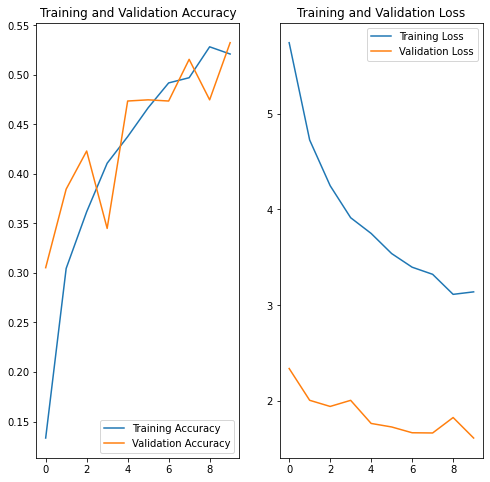

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Checking succession rate

#### Loading test csv

In [24]:
test_df = pd.read_csv("../plantbase/data/test_data.csv").drop(columns = "Unnamed: 0")

In [25]:
test_df = test_df[['id', 'genus']]
test_df.head()

,id,genus
0,100035,Verbascum
1,100058,Trifolium
2,100186,Veronica
3,100238,Campanula
4,1003,Geranium


In [26]:
columns = np.sort(test_df.genus.unique())
columns

array(['Ajuga', 'Allium', 'Campanula', 'Cirsium', 'Crataegus', 'Gentiana',
       'Geranium', 'Iris', 'Malva', 'Narcissus', 'Ophrys', 'Rosa',
       'Trifolium', 'Verbascum', 'Veronica', 'Viola'], dtype=object)

In [27]:
rename_columns = {}
col_index = 0
for n in columns:
    rename_columns[col_index] = n
    col_index += 1
    
rename_columns

{0: 'Ajuga',
 1: 'Allium',
 2: 'Campanula',
 3: 'Cirsium',
 4: 'Crataegus',
 5: 'Gentiana',
 6: 'Geranium',
 7: 'Iris',
 8: 'Malva',
 9: 'Narcissus',
 10: 'Ophrys',
 11: 'Rosa',
 12: 'Trifolium',
 13: 'Verbascum',
 14: 'Veronica',
 15: 'Viola'}

#### Loading test images using tensorflow load_img and img_to_array

In [28]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [29]:
X_list = []
y_list = []

for index, row in test_df.iterrows():
    img = load_img(rf"./plantbase_images/test/{row.id}.jpg", target_size=(256, 256))
    img = tensorflow.keras.preprocessing.image.img_to_array(img)
    #img = tensorflow.expand_dims(img, 0)
    X_list.append(img)
    y_list.append((row.genus, row.id))

In [30]:
y_true_df = pd.DataFrame(y_list, columns = ['true_genus', 'id'])
y_true_df.head()

,true_genus,id
0,Verbascum,100035
1,Trifolium,100058
2,Veronica,100186
3,Campanula,100238
4,Geranium,1003


In [31]:
X_test = np.stack(X_list, axis=0)

In [32]:
y_pred = model.predict(X_test)

In [33]:
y_pred.shape

(1341, 16)

In [34]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.rename(columns = rename_columns)
y_pred_df.head()

,Ajuga,Allium,Campanula,Cirsium,Crataegus,Gentiana,Geranium,Iris,Malva,Narcissus,Ophrys,Rosa,Trifolium,Verbascum,Veronica,Viola
0,-1955.697632,-4017.361572,-3911.848633,-2979.287354,-4699.749512,2480.772461,-2298.172852,2530.827393,-3550.234863,721.108826,-923.877380,-518.632751,-1603.248169,2039.562012,-4449.628418,903.869080
1,550.452209,-2264.700684,404.961426,-427.492157,-2785.292725,1016.676208,405.649567,529.972595,-186.655899,-2914.225830,-1664.608154,-770.537781,921.501953,-144.799347,875.776550,-815.165405
2,1229.191772,-625.539185,806.125977,-693.298950,-1929.905151,1552.443848,-189.601944,-61.851639,-233.293961,-1585.032837,-702.418701,-1618.870728,-642.833984,334.486725,2077.717285,205.239044
3,898.851013,-1018.079529,443.087494,1123.467896,-2726.366699,855.868469,-229.063065,-155.908188,507.052368,-4109.943359,-1610.630493,-295.803040,-317.360992,-1828.151855,-387.799072,-819.379517
4,-503.884674,-216.240021,944.205322,-846.960632,-3644.646484,-873.205322,1044.879883,-873.322693,539.074219,-3274.610596,59.534683,-1393.664551,-452.987000,-2128.048340,35.963600,185.205750


In [35]:
y_true = np.stack(y_list, axis = 0)

In [36]:
y_pred_df['pred_genus'] = y_pred_df.idxmax(axis = 1)
y_pred_df['pred_genus']

0            Iris
1        Gentiana
2        Veronica
3         Cirsium
4        Geranium
5       Verbascum
6       Verbascum
7        Gentiana
8        Gentiana
9        Geranium
10      Campanula
11       Geranium
12       Gentiana
13      Campanula
14      Verbascum
15      Verbascum
16       Veronica
17       Gentiana
18       Gentiana
19      Campanula
20          Malva
21          Ajuga
22      Campanula
23      Campanula
24       Gentiana
25      Verbascum
26       Gentiana
27         Ophrys
28       Gentiana
29       Gentiana
          ...    
1311    Campanula
1312     Gentiana
1313     Veronica
1314         Iris
1315     Gentiana
1316     Geranium
1317    Campanula
1318    Verbascum
1319     Geranium
1320     Gentiana
1321        Viola
1322    Campanula
1323     Gentiana
1324     Gentiana
1325        Malva
1326     Veronica
1327     Geranium
1328         Rosa
1329     Gentiana
1330     Gentiana
1331         Rosa
1332    Verbascum
1333    Verbascum
1334     Gentiana
1335      

In [37]:
prediction_review = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [38]:
prediction_vec_df = y_pred_df[['pred_genus']].copy()
prediction_vec_df['true_genus'] = y_true_df['true_genus'].copy()
prediction_vec_df['result'] = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [39]:
prediction_vec_df['false'] = prediction_vec_df['result'].apply(lambda x: 1 if x == False else 0)
prediction_vec_df['true'] = prediction_vec_df['result'].apply(lambda x: 1 if x == True else 0)
prediction_vec_df.head(2)

,pred_genus,true_genus,result,false,true
0,Iris,Verbascum,False,1,0
1,Gentiana,Trifolium,False,1,0


In [40]:
true_pos_neg = prediction_vec_df.groupby('true_genus').sum().drop(columns=['result'])
true_pos_neg['percent_true'] = true_pos_neg['true'] / (true_pos_neg['true'] + true_pos_neg['false'])

In [41]:
success_ratio = round(true_pos_neg[['percent_true']]*100).sort_values(by='percent_true', ascending=False)

In [42]:
success_ratio

,percent_true
true_genus,
Gentiana,76.0
Ajuga,52.0
Campanula,52.0
Cirsium,51.0
Verbascum,50.0
Geranium,42.0
Malva,39.0
Veronica,39.0
Rosa,38.0


# VGG model

In [43]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense

In [46]:
def load_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=(256,256,3))
    return model

In [47]:
model = load_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [48]:
def update_model(model):
    # Set the first layers to be untrainable
    model.trainable = False
    
    # Add layers to the mdoel
    flatten_layer = Flatten()
    dense_layer = Dense(500, activation='relu')
    prediction_layer = Dense(16, activation='softmax')

    model = Sequential([
        model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    
    return model

In [49]:
model = update_model(model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               16384500  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                8016      
Total params: 31,107,204
Trainable params: 16,392,516
Non-trainable params: 14,714,688
_________________________________________________________________


In [77]:
from tensorflow.keras.optimizers import Adam
def compile_model(model):
    model.compile(optimizer=Adam(lr=0.001), loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    
    return model

In [78]:
def build_model():
    
    model = load_model()
    model = update_model(model)
    model = compile_model(model)
    
    return model

model = build_model()

In [83]:
vgg_model = VGG16(input_shape=(256,256,3), weights="imagenet", include_top=False)

modelvgg = Sequential()
modelvgg.add(vgg_model)
modelvgg.add(Flatten())
modelvgg.add(Dense(16, activation='softmax'))    
modelvgg.compile(optimizer='adam',
          loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [ ]:
epochs=3
history = modelvgg.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    class_weight=class_weight,
    epochs = epochs)

Epoch 1/3
 23/108 [=====>........................] - ETA: 44:06 - loss: 5.9078 - accuracy: 0.1201

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()